In [5]:
import math
import copy
import os
import time
import enum
import argparse
import polars as pl
# Visualization related imports
import matplotlib.pyplot as plt
import seaborn
from torch.utils.data import DataLoader, Dataset
# Deep learning related imports
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torch.hub import download_url_to_file
from torch.utils.data import Dataset
# Data manipulation related imports
# from torchtext.data import Dataset, BucketIterator, Field, Example
import spacy
import seaborn as sns
import pandas as pd
import numpy as np
import datetime

In [6]:
class BatteryData(Dataset):
    def __init__(self, data_dir, processor, final_cols) -> None:
        super().__init__()
        self.processor = processor
        # self.ares = self.load_data(data_dir)
        data = pl.read_parquet(data_dir)
        self.ares, self.ares_y = self.processor.process_data(data.select(final_cols))

    def __len__(self):
        return self.ares.shape[0]
    
    def __getitem__(self, index):
        X = self.ares
        Y = self.ares_y
        return X[index], Y[index]
    
    def load_data(self, data_dir):
        path_list = os.listdir(data_dir)
        data = []
        for item in os.listdir(data_dir):
            data.append(self.processor.process_data(pl.read_parquet(os.path.join(data_dir,item))))
        res = pl.concat(data)
        return res
    
    @staticmethod
    def get_data_info(data_dir):
        data_info={}
        for root, dirs, files in os.walk(data_dir):
            for file in files:
                file_path = os.path.join(root, file)
                print(f"file: {file}")
                data = pl.read_parquet(file_path)
                yield data
class processor:
    def __init__(self, groups, seq_len, step_size) -> None:
        self.groups = groups
        self.seq_len = seq_len
        self.step_size = step_size
    
    def process_data(self, data:pl.DataFrame):
        final_res = []
        final_y = []
        for item in data.groupby(self.groups):
            data_tmp = item[1]
            data_tmp = data_tmp.drop('cycle')
            l = data_tmp.shape[0]
            if l < self.seq_len:
                continue
            # steps = int((l-self.seq_len)//self.step_size+1)
            steps = int(l-self.seq_len*2+self.step_size)
            for i in range(steps+1):
                X_tensor = torch.from_numpy(data_tmp[i:i+self.seq_len].to_numpy())
                y_tensor = torch.from_numpy(data_tmp[i+self.step_size:i+self.step_size+self.seq_len].select('D135_diff').to_numpy())
                final_res.append(X_tensor)
                final_y.append(y_tensor)
            # X_tensor = torch.from_numpy(data_tmp[-self.seq_len-self.step_size:-self.step_size].to_numpy())
            # if X_tensor.shape[0] < 10: continue
            # y_tensor = torch.from_numpy(data_tmp[-self.seq_len:].select('D135_diff').to_numpy())
            # final_res.append(X_tensor)
            # final_y.append(y_tensor)
        ares = torch.cat(final_res)
        ares = ares.reshape((-1, self.seq_len, data_tmp.shape[1]))
        ares_y = torch.cat(final_y)
        ares_y = ares_y.reshape((-1, self.seq_len, 1))
        return ares, ares_y

In [7]:
import torch
import math
import copy
import os
import time
import enum
import argparse
import polars as pl
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torch.hub import download_url_to_file
import seaborn as sns


class MLP(nn.Module):
    def __init__(self, model_dimension):
        super(MLP, self).__init__()
        self.hidden1 = nn.Sequential(
            nn.Linear(
                in_features=model_dimension,
                out_features=256,
                bias=True
            ),
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.classifica = nn.Linear(64, 2)

    def forward(self, x):
        fc1 = F.dropout(self.hidden1(x))
        fc2 = F.dropout(self.hidden2(fc1))
        output = self.classifica(fc2)
        return F.log_softmax(output)


class PositionalEncoding(nn.Module):

    def __init__(self, model_dimension, dropout_probability, expected_max_sequence_length=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_probability)
        position_id = torch.arange(0, expected_max_sequence_length).unsqueeze(1)
        frequencies = torch.pow(10000., -torch.arange(0, model_dimension, 2, dtype=torch.float) / model_dimension)

        # Checkout playground.py for visualization of how these look like (it's super simple don't get scared)
        positional_encodings_table = torch.zeros(expected_max_sequence_length, model_dimension)
        positional_encodings_table[:, 0::2] = torch.sin(position_id * frequencies)  # sine on even positions
        positional_encodings_table[:, 1::2] = torch.cos(position_id * frequencies)  # cosine on odd positions

        self.register_buffer('positional_encodings_table', positional_encodings_table)

    def forward(self, embeddings_batch):
        assert embeddings_batch.ndim == 3 and embeddings_batch.shape[-1] == self.positional_encodings_table.shape[1], \
            f'Expected (batch size, max token sequence length, model dimension) got {embeddings_batch.shape}'

        positional_encodings = self.positional_encodings_table[:embeddings_batch.shape[1]]
        return self.dropout(embeddings_batch + positional_encodings)

class DTN_model(nn.Module):
    def __init__(self, model_dimension, number_of_heads, number_of_layers,d_hid, dropout_probability, number_of_var,
                 hidden_dimension_list,in_channel, out_channel, kernel_size, stride):
        super().__init__()
        # Periodic Embeddings
        # two different encoders and decoders
        EncoderLayer = nn.TransformerEncoderLayer(d_model=model_dimension,
                                                  nhead=number_of_heads,dim_feedforward=d_hid, batch_first=True)
        self.encoder = nn.TransformerEncoder(EncoderLayer, num_layers=number_of_layers)
        self.fw_embedding = nn.Linear(number_of_var, model_dimension)
        self.bw_embedding = nn.Linear(number_of_var, model_dimension)
        self.pos_embedding = PositionalEncoding(model_dimension, dropout_probability)

        self.decoder = nn.Conv1d(in_channel, out_channel, kernel_size, stride)
        self.mlp = nn.ModuleList([nn.Sequential(nn.Linear(int((model_dimension - kernel_size)/stride+1),hidden_dimension_list[0]),nn.ReLU())]
                                 +[nn.Sequential(nn.Linear(hidden_dimension_list[i-1],hidden_dimension_list[i]),nn.ReLU()) for i in range(1,len(hidden_dimension_list))])
        self.init_params()

    def init_params(self):
        # I tested both PyTorch's default initialization and this, and xavier has tremendous impact! I didn't expect
        # that the model's perf, with normalization layers, is so dependent on the choice of weight initialization.
        for name, p in self.named_parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    @staticmethod
    def get_key_padding_mask(tokens):
        tmp=tokens[:,:,0].squeeze()
        tmp = tmp.reshape((-1,tokens.shape[1]))
        key_padding_mask = torch.zeros(tmp.size())
        key_padding_mask[tmp == 0] = -torch.inf
        return key_padding_mask
    
    @staticmethod
    def get_bw_mask(bw_tensor):
        bw_mask = nn.Transformer.generate_square_subsequent_mask(bw_tensor.size()[-2])
        return bw_mask
    
    def encode(self, input, src_mask):
        input_embeddings = self.fw_embedding(input)
        input_embeddings = self.pos_embedding(input_embeddings)
        input_repr = self.encoder(input_embeddings, src_key_padding_mask=src_mask)
        return input_repr
    
    def decode(self, input):
        return bw_repr
        
    def forward(self, input, src_mask):
        input_repr = self.encode(input, src_mask)
        # decode_repr = self.decoder(input_repr.permute([0,2,1])).permute([0,2,1])
        decode_repr = self.decoder(input_repr)
        for m in self.mlp:
            decode_repr = m(decode_repr)
        # for m in self.mlp:
        #     input_repr = m(input_repr)
        # pred = F.log_softmax(input_repr,dim=1)
        return decode_repr

In [21]:
def train_loop(data_dir, model, loss_fn, optimizer, final_cols):
    size = 0
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    train_loss=0
    batch = 0
    for file in [x for x in os.listdir(data_dir) if 'parquet' in x]:
        print(os.path.join(data_dir,file))
        # key = file.split('_')[0]
        battery_data = BatteryData(os.path.join(data_dir,file), dataProcess, final_cols)
        dataloader = DataLoader(dataset=battery_data,batch_size=2,shuffle=True,num_workers=0)
        size += len(dataloader.dataset)
        # loss_file[key] = []
        tmp_loss=[]
        for _batch, (X, y) in enumerate(dataloader):
            # print(batch)
            # Compute prediction and loss
            # tmp = torch.ones(y.shape)
            # y2 = tmp-y
            # y = y.unsqueeze(dim=2)
            # y2 = y2.unsqueeze(dim=2)
            # new_y = torch.cat([y,y2],dim=2)
            # new_y = new_y.cuda()
            # print("X",X.shape)
            pred = model(X.float().cuda(), model.get_key_padding_mask(X.cuda()).float().cuda())

            loss = loss_fn(pred.reshape((X.shape[0],X.shape[1],-1)).float(), y.float().cuda())
            train_loss+=loss.item()
            tmp_loss.append(loss.item())
            # Backpropagation
            loss.backward()
            # for name, param in MyModel.named_parameters():
            #     if param.requires_grad and param.grad is not None:
            #         print(name)
            #         print(param.grad)
            #         print(f"grad shape: {param.grad.shape}")
            optimizer.step()
            optimizer.zero_grad()
            batch+=1
            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                # loss_train.append(sum(tmp_loss)/len(tmp_loss))
                tmp_loss=[]
    return train_loss

## 训练charge_data

In [8]:
model_dimension = 512
number_of_heads = 4
number_of_var = 114
number_of_layers = 3
dropout_probability = 0.4
hidden_dimension_list = [512,64,16,1]
d_hid = 512
in_channel = 10
out_channel = 10
kernel_size = 10
stride = 2

In [9]:
dataProcess = processor(['cycle'], 10, 5)

In [10]:
MyModel = DTN_model(model_dimension, number_of_heads, number_of_layers,d_hid, dropout_probability,
                    number_of_var, hidden_dimension_list, in_channel,out_channel,kernel_size,stride)

In [11]:
optimizer = Adam(MyModel.parameters(),lr=0.000005, betas=(0.9, 0.98), eps=1e-9)

e:\anaconda\envs\LLM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\anaconda\envs\LLM\Lib\site-packages\huggingface_hub\utils\_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [12]:
MyModel = MyModel.cuda()
loss = nn.MSELoss()
loss=loss.cuda()
final_cols = [f"D135_{i}_dv" for i in range(1,113)]+['D135_diff','D135_std_max']+['cycle']

In [22]:
epochs = 60
batch_size=4
all_losses=[]
if __name__ == "__main__":
    for epoch in range(1,epochs+1):
        train_loss = train_loop('processed_data/normal_sample/charge_data',MyModel,loss,optimizer, final_cols)
        all_losses.append(train_loss)
        if epoch % 20 == 0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': MyModel.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    }, f"model/10_5_moredata_model_charge_epoch{epoch}.pt")

processed_data/normal_sample/charge_data\D105_4_5.parquet


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_7036\3444186630.py:43: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  for item in data.groupby(self.groups):


loss: 88.871727  [  202/ 2246]
loss: 65.047058  [  402/ 2246]
loss: 139.734940  [  602/ 2246]
loss: 122.279594  [  802/ 2246]
loss: 43.788677  [ 1002/ 2246]
loss: 42.360901  [ 1202/ 2246]
loss: 44.953510  [ 1402/ 2246]
loss: 28.599085  [ 1602/ 2246]
loss: 7.596233  [ 1802/ 2246]
loss: 20.840744  [ 2002/ 2246]
loss: 31.566145  [ 2202/ 2246]
processed_data/normal_sample/charge_data\D107_4_5.parquet
loss: 68.717239  [ 2402/ 3920]
loss: 27.295774  [ 2602/ 3920]
loss: 36.797619  [ 2802/ 3920]
loss: 19.154261  [ 3002/ 3920]
loss: 22.457293  [ 3202/ 3920]
loss: 28.605238  [ 3402/ 3920]
loss: 61.561512  [ 3602/ 3920]
loss: 8.939695  [ 3802/ 3920]
processed_data/normal_sample/charge_data\D119_4_5.parquet
loss: 25.354761  [ 4002/ 6345]
loss: 22.621979  [ 4202/ 6345]
loss: 9.799879  [ 4402/ 6345]
loss: 24.826763  [ 4602/ 6345]
loss: 12.058696  [ 4802/ 6345]
loss: 27.882832  [ 5002/ 6345]
loss: 11.400095  [ 5202/ 6345]
loss: 19.349066  [ 5402/ 6345]
loss: 30.880451  [ 5602/ 6345]
loss: 30.928541  

KeyboardInterrupt: 

In [31]:
losses_res = pd.DataFrame({'epoch':[i for i in range(1,epochs+1)], 'total_loss':all_losses})
losses_res.to_csv('result_plot/10_5_charge_losses.csv', index=False)

In [17]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [18]:
class processor2:
    def __init__(self, groups, seq_len, step_size) -> None:
        self.groups = groups
        self.seq_len = seq_len
        self.step_size = step_size
    
    def process_data(self, data:pl.DataFrame):
        final_res = []
        final_y = []
        for item in data.groupby(self.groups):
            data_tmp = item[1]
            data_tmp = data_tmp.drop('cycle')
            l = data_tmp.shape[0]
            if l < self.seq_len:
                continue
            steps = int((l-self.seq_len)//self.step_size+1)
            for i in range(steps-1):
                X_tensor = torch.from_numpy(data_tmp[self.step_size*i:self.step_size*i+self.seq_len].drop('samplingtimesec').to_numpy())
                y_tensor = torch.from_numpy(data_tmp[self.step_size*(i+1):self.step_size*(i+1)+self.seq_len].select(['D135_diff','samplingtimesec']).to_numpy())
                final_res.append(X_tensor)
                final_y.append(y_tensor)
            X_tensor = torch.from_numpy(data_tmp[-self.seq_len-self.step_size:-self.step_size].drop('samplingtimesec').to_numpy())
            if X_tensor.shape[0] < 10: continue
            y_tensor = torch.from_numpy(data_tmp[-self.seq_len:].select(['D135_diff','samplingtimesec']).to_numpy())
            final_res.append(X_tensor)
            final_y.append(y_tensor)
        ares = torch.cat(final_res)
        ares = ares.reshape((-1, self.seq_len, data_tmp.shape[1]-1))
        # print(f"final_y[0]:{final_y[0].shape}")
        ares_y = torch.cat(final_y)
        ares_y = ares_y.reshape((-1, self.seq_len, 2))
        return ares, ares_y

In [19]:
def getTestResult(data_dir, model, loss_fn, dataProcess, final_cols):
    # model.eval()
    size = 0
    batch = 0
    loss_file = {}
    for file in [x for x in os.listdir(data_dir) if 'parquet' in x]:
        print(os.path.join(data_dir,file))
        key = file.split('.')[0]
        battery_data = BatteryData(os.path.join(data_dir,file), dataProcess, final_cols)
        dataloader = DataLoader(dataset=battery_data,batch_size=1,shuffle=False,num_workers=1)
        size += len(dataloader.dataset)
        loss_file[key] = {'loss':[],'samplingtimesec':[]}
        for _batch, (X, y) in enumerate(dataloader):
            y_true = torch.unsqueeze(y[:,:,0], 2)
            timesec = np.squeeze(y[:,:,1].numpy())[-1]
            pred = model(X.float().cuda(), model.get_key_padding_mask(X.cuda()).float().cuda())
            loss = loss_fn(pred.reshape((X.shape[0],X.shape[1],-1)), y_true.cuda())
            batch+=1
            loss_file[key]['loss'].append(loss.item())
            loss_file[key]['samplingtimesec'].append(timesec)
            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        del battery_data
        del dataloader
    return loss_file

In [20]:
dataProcess = processor2(['cycle'], 10, 5)

In [21]:
final_cols = [f"D135_{i}_dv" for i in range(1,113)]+['D135_diff','D135_std_max']+['cycle','samplingtimesec']

In [22]:
loss_fn = nn.MSELoss()
loss_fn = loss_fn.cuda()
loss_file = getTestResult('processed_data/neg_sample/charge_data',MyModel,loss_fn,dataProcess, final_cols)

processed_data/neg_sample/charge_data/D1_4_5.parquet
loss: 1.589222  [  101/  799]
loss: 0.527591  [  201/  799]
loss: 0.616997  [  301/  799]
loss: 1.350950  [  401/  799]
loss: 1.067018  [  501/  799]
loss: 0.671005  [  601/  799]
loss: 1.175538  [  701/  799]
processed_data/neg_sample/charge_data/D13_4_5.parquet
loss: 2.820241  [  801/ 1925]
loss: 0.774233  [  901/ 1925]
loss: 0.046346  [ 1001/ 1925]
loss: 0.469193  [ 1101/ 1925]
loss: 0.350453  [ 1201/ 1925]
loss: 0.546718  [ 1301/ 1925]
loss: 1.384350  [ 1401/ 1925]
loss: 181.517852  [ 1501/ 1925]
loss: 0.563063  [ 1601/ 1925]
loss: 1.331108  [ 1701/ 1925]
loss: 0.340165  [ 1801/ 1925]
loss: 0.301855  [ 1901/ 1925]
processed_data/neg_sample/charge_data/D2_4_5.parquet
loss: 3.280433  [ 2001/ 3048]
loss: 0.081352  [ 2101/ 3048]
loss: 0.385342  [ 2201/ 3048]
loss: 0.081069  [ 2301/ 3048]
loss: 1.694262  [ 2401/ 3048]
loss: 0.616682  [ 2501/ 3048]
loss: 0.357041  [ 2601/ 3048]
loss: 1.869443  [ 2701/ 3048]
loss: 15.089876  [ 2801/ 304

In [23]:
def format_time(sampletime):
    time_instance = datetime.datetime.fromtimestamp(sampletime/1000)
    return time_instance .strftime("%Y-%m-%d %H:%M:%S")
    # return time_instance .strftime("%Y-%m-%d")

In [24]:
def plot_abnormal_score_trend(loss_file, car):
    res_file = loss_file[f"{car}_4_5"].copy()
    res_file['samplingtimesec'] = [format_time(x) for x in res_file['samplingtimesec']]
    n_len = len(res_file['loss'])
    df = pd.DataFrame({'samplingtimesec':res_file['samplingtimesec'], 'loss':res_file['loss']})
    df = df.sort_values(by='samplingtimesec').reset_index(drop=True)
    plt.figure(figsize=(20,10))
    idx_l = list(range(0, n_len))[::200]
    idx_r = [df['samplingtimesec'][x][:10] for x in idx_l]
    # idx_r = [str(x)[11:] for x in idx_r]
    plt.xticks(idx_l,idx_r)
    plt.xlabel('time')
    plt.ylabel('MSE loss')
    plt.plot(df['loss'],label=f"{car} charge_data", linewidth=2)
    # plt.plot(tmp['D135_diff_y'],'--', label="smooth data", linewidth=4)
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    plt.savefig(f"result_plot/{car}_charge_mse.png")
    return

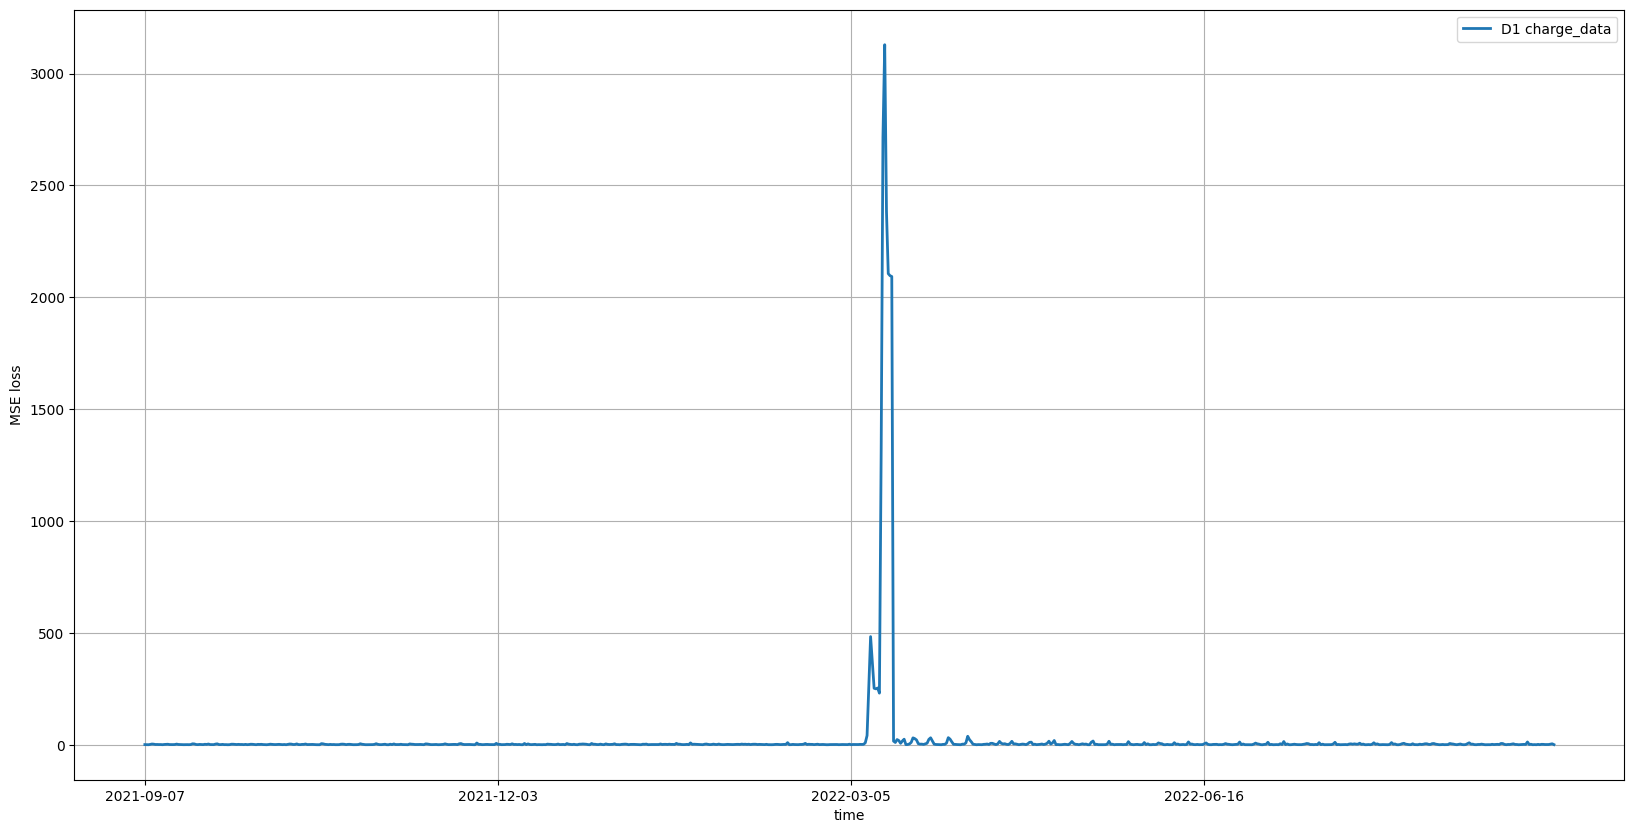

<Figure size 640x480 with 0 Axes>

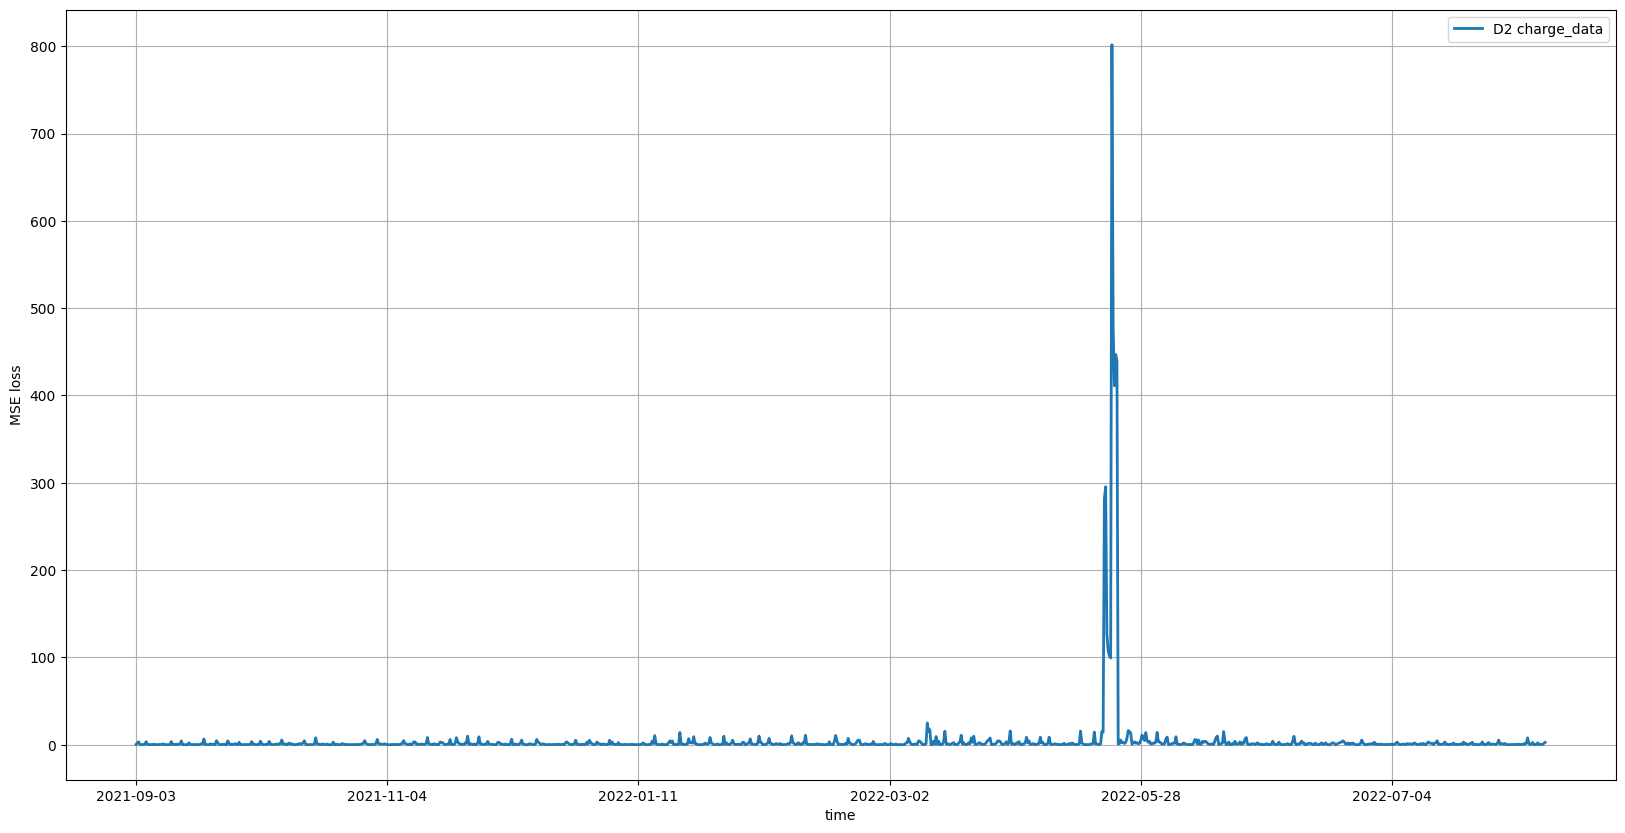

<Figure size 640x480 with 0 Axes>

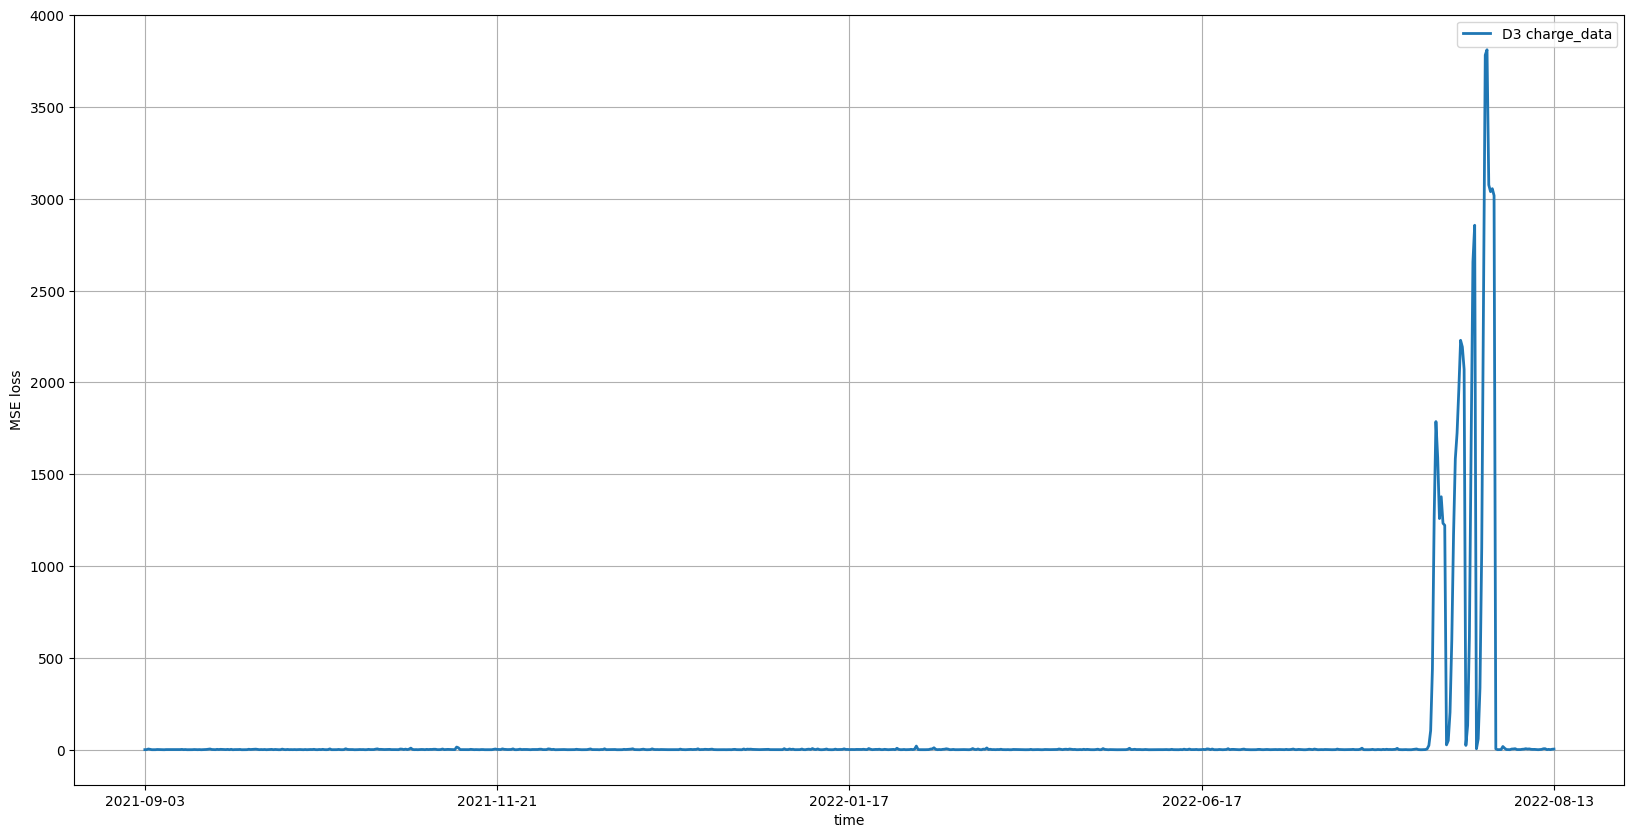

<Figure size 640x480 with 0 Axes>

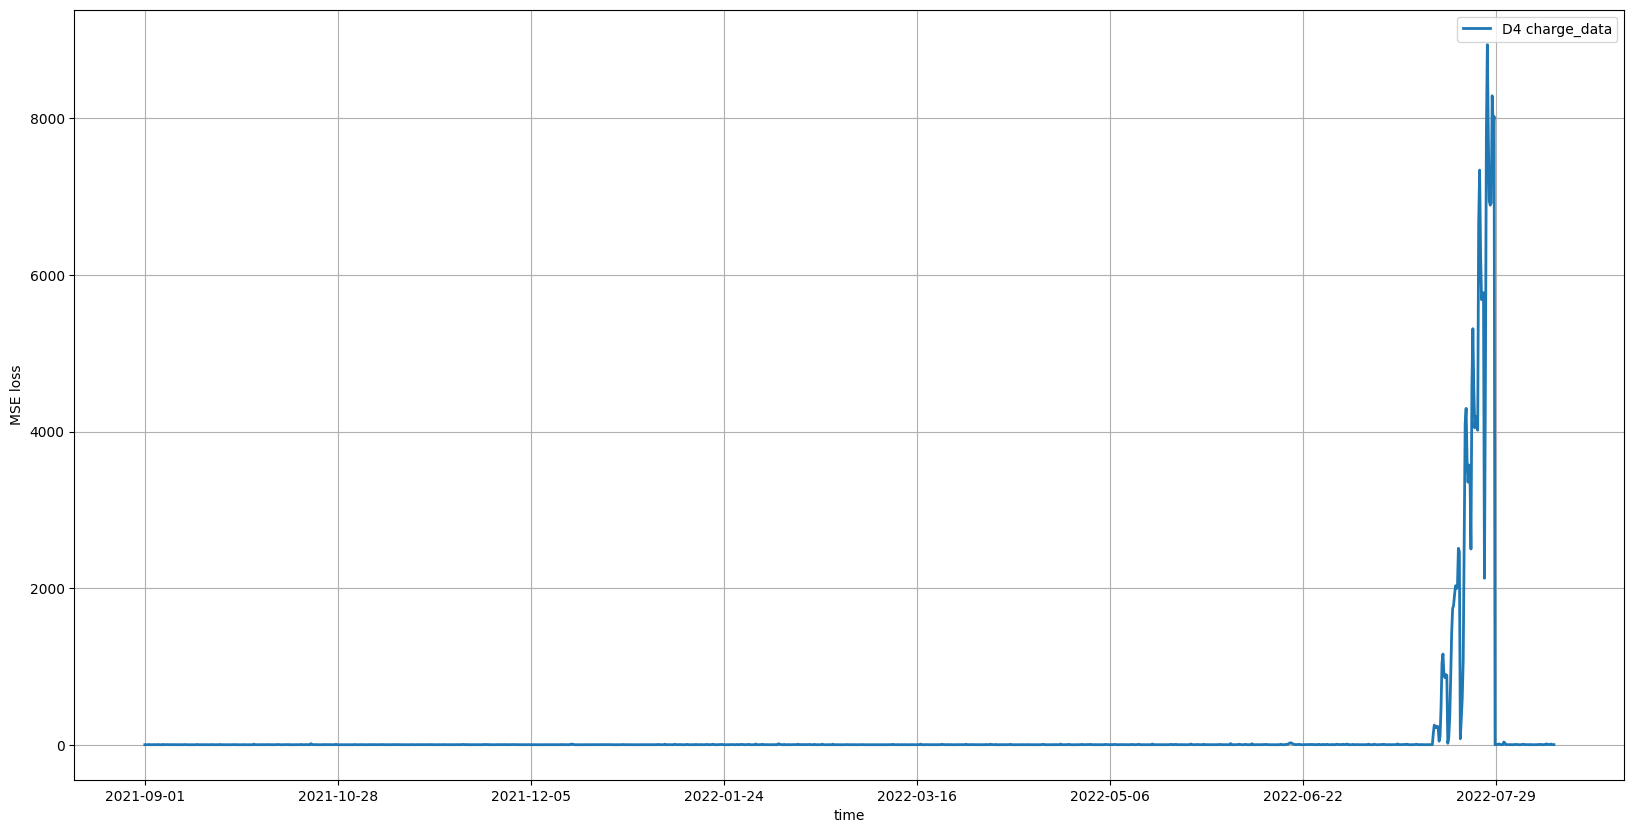

<Figure size 640x480 with 0 Axes>

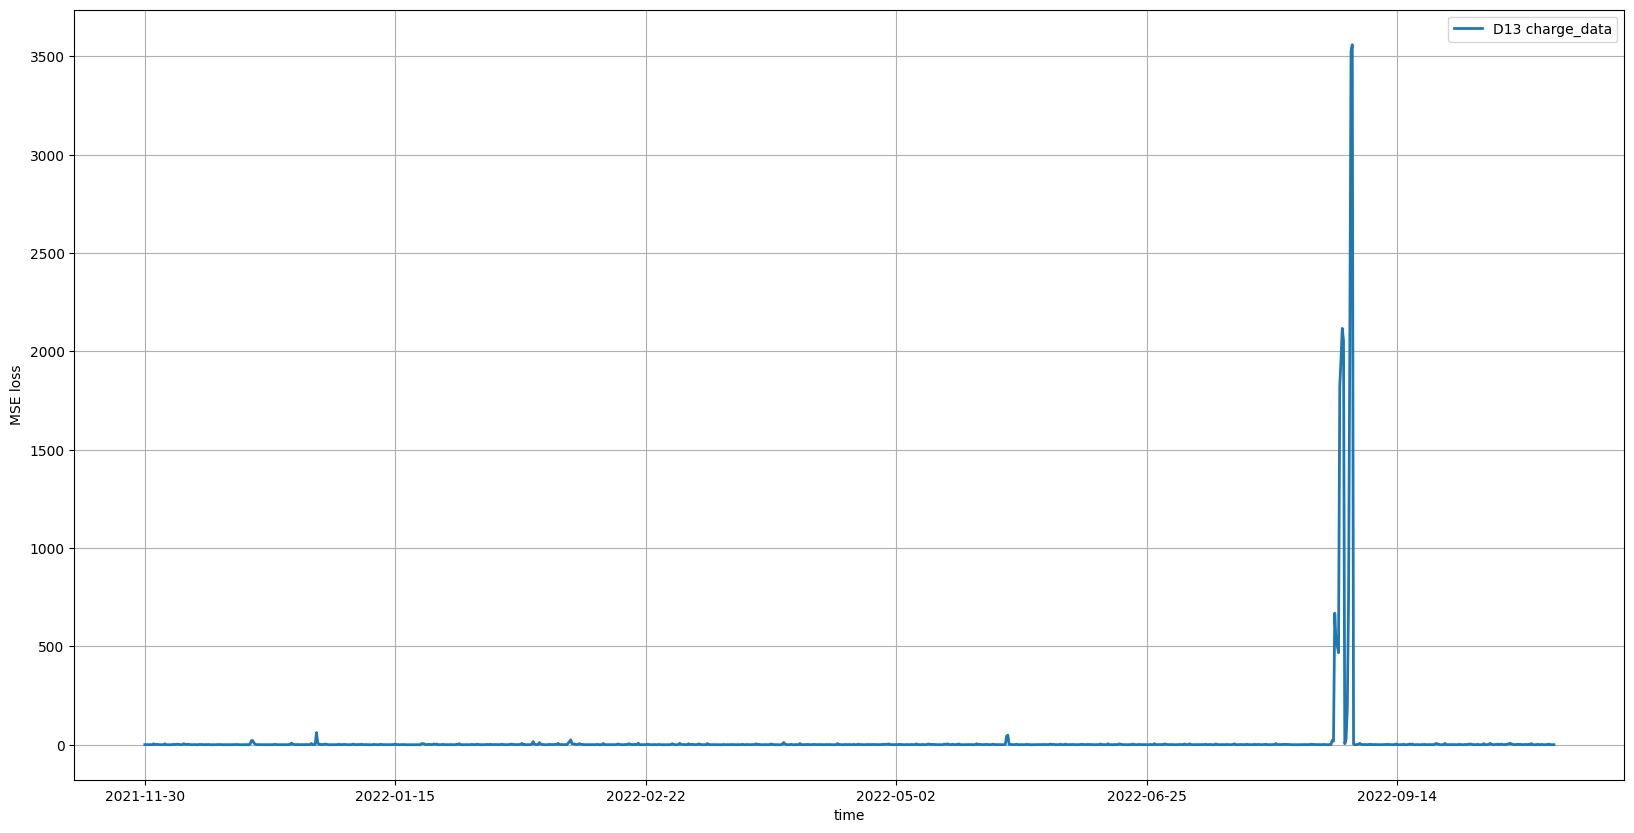

<Figure size 640x480 with 0 Axes>

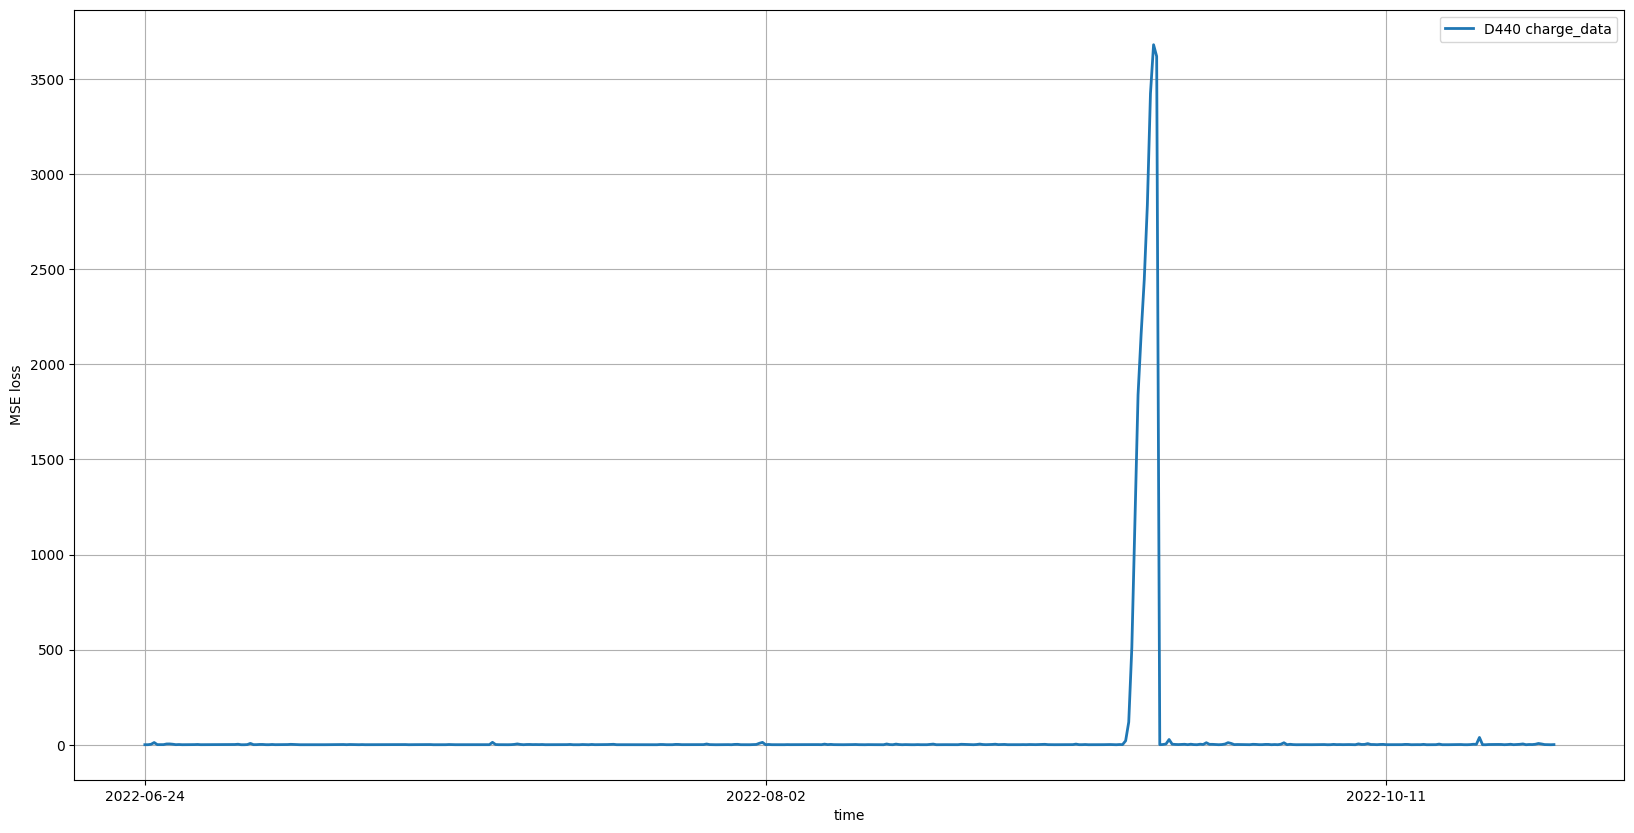

<Figure size 640x480 with 0 Axes>

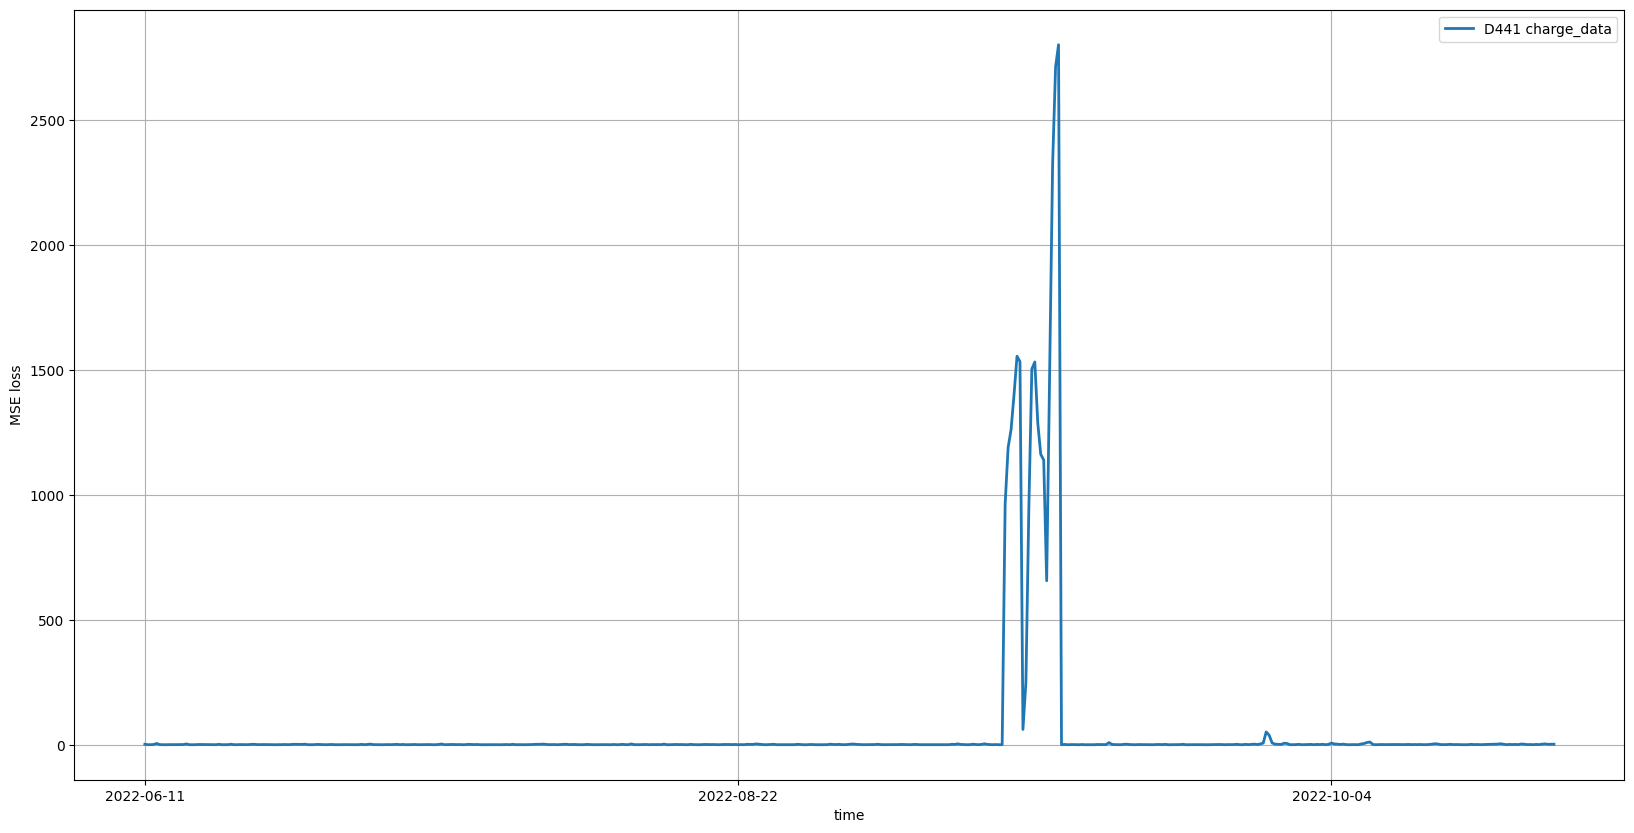

<Figure size 640x480 with 0 Axes>

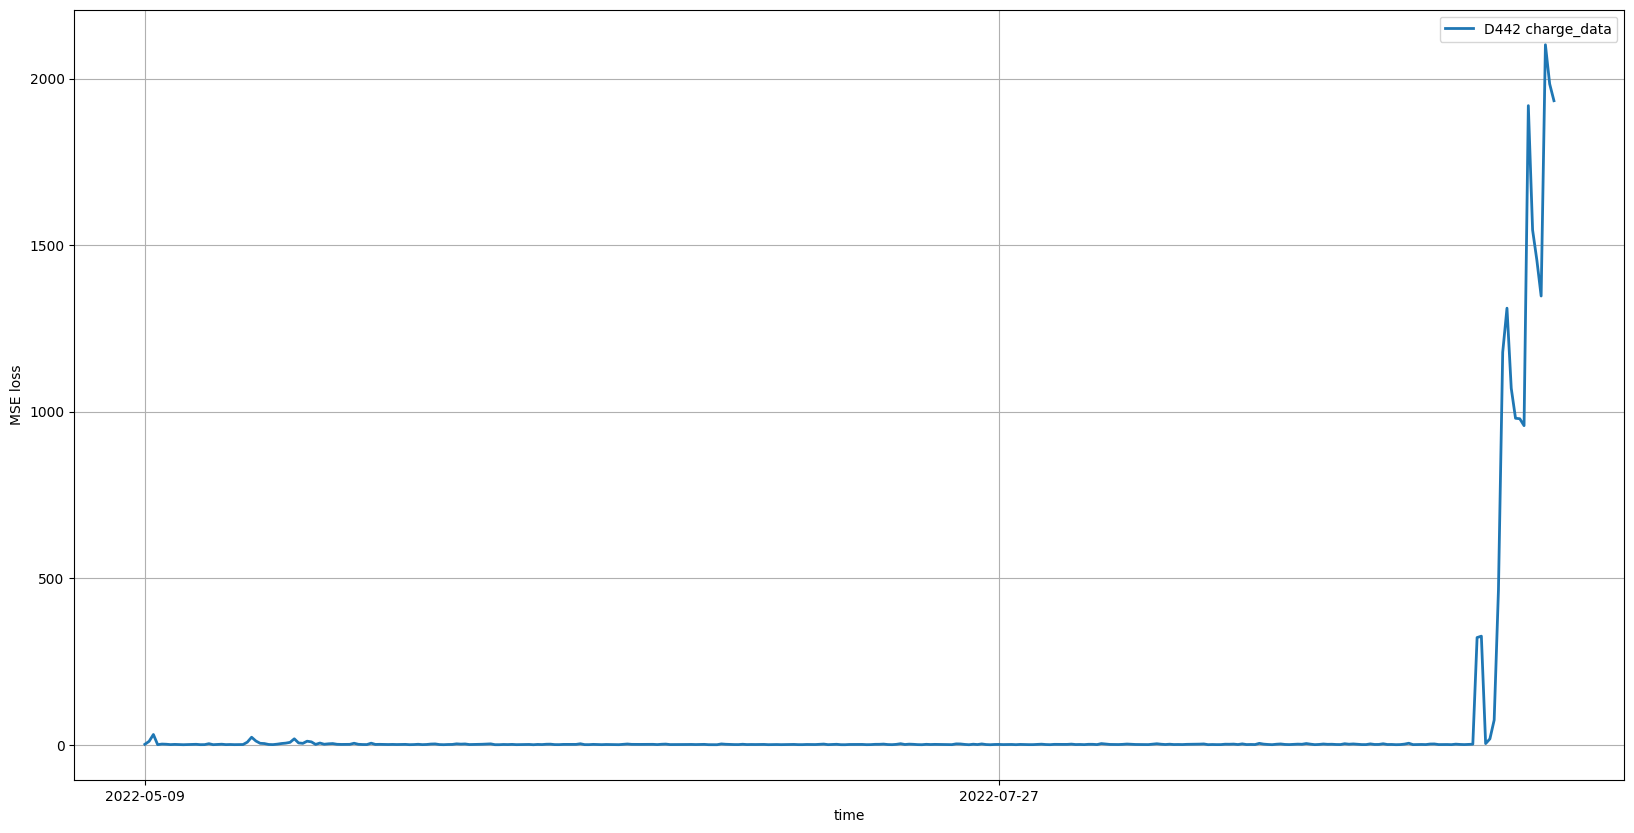

<Figure size 640x480 with 0 Axes>

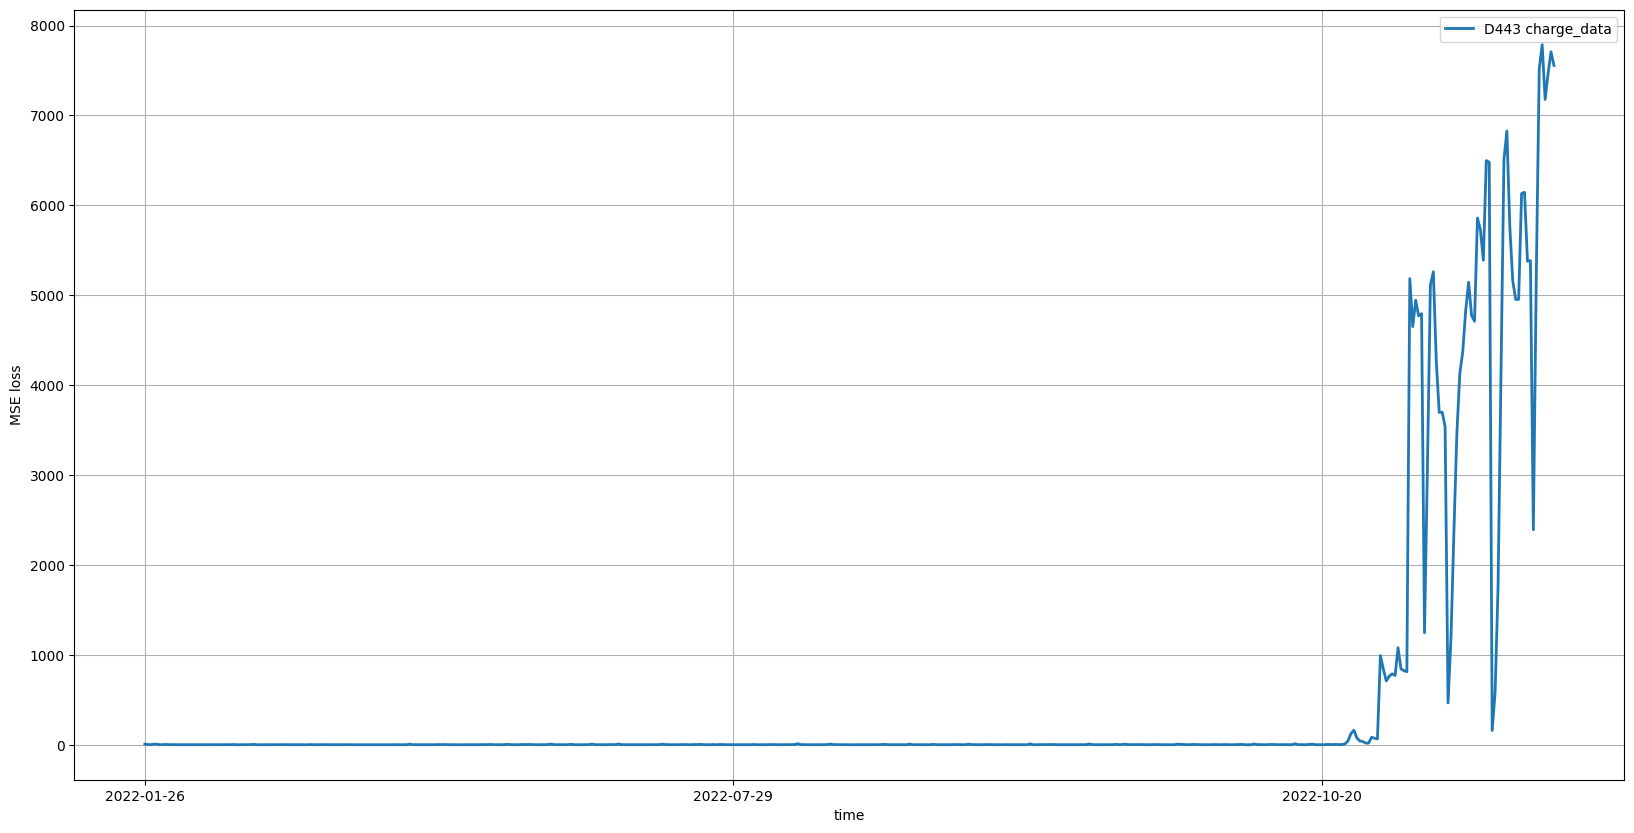

<Figure size 640x480 with 0 Axes>

In [25]:
car_name=['D1','D2','D3','D4','D13','D440','D441','D442','D443']
for car in car_name:
    plot_abnormal_score_trend(loss_file, car)

In [32]:
tmp = pd.DataFrame(loss_file['D3_4_5'])
tmp=tmp.sort_values(by='samplingtimesec').reset_index(drop=True)
format_time(tmp['samplingtimesec'][tmp[tmp.loss>100].index.min()])

'2022-07-25 00:05:55'

In [26]:
np.save('result_plot/abnormal_newest_cars_mse.npy', loss_file)